# Calculating color of a thin-film on top of a Si wafer

In [1]:
from tmm import (coh_tmm, unpolarized_RT, ellips,
                 position_resolved, find_in_structure_with_inf)

import colorpy.illuminants
import colorpy.colormodels
from tmm import color

from numpy import pi, linspace, inf, array
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

%matplotlib inline

In [2]:
def plot_film_thickness_vs_color(film_material, max_film_thickness=600.0, N_samples=50, set_extinction_to_zero=False):

    fn_film_refrac = Path(".")/f"{film_material}_refractive_index.csv"
    if not fn_film_refrac.exists():
        raise Exception(f"Please download the refractive index of {film_material}"
                        " from https://refractiveindex.info and save it to"
                        f" {fn_film_refrac}")
        
    df = pd.read_csv(fn_film_refrac, comment='#')
    if not list(df.columns) == ['Wavelength, µm', 'n', 'k']:
        raise Exception("CSV-format not correct")
    
    # the wavelength is needed in nanometers
    film_wavelength = 1000.0 * df['Wavelength, µm']
    s = 1.0
    if set_extinction_to_zero:
        s = 0.0
    # refractive index is needed as `n + ik` (n: refractive index, k: extinction coefficient)
    film_complex_ri = df['n'] + 1.0j*df['k'].fillna(0.0)*s
    film_n_fn = interp1d(film_wavelength, film_complex_ri, kind='linear', fill_value="extrapolate", bounds_error=False)
    
    x = np.linspace(400, 700, 100)
    plt.figure()
    plt.plot(x, film_n_fn(x).real, label="n")
    plt.plot(x, film_n_fn(x).imag, label="k")
    plt.legend()
    plt.title(film_material)
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("refractive index [1]")

    
    Si_n_data = [[400, 5.57 + 0.387j],
             [450, 4.67 + 0.145j],
             [500, 4.30 + 7.28e-2j],
             [550, 4.08 + 4.06e-2j],
             [600, 3.95 + 2.57e-2j],
             [650, 3.85 + 1.64e-2j],
             [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')

    # air refractive index
    air_n_fn = lambda wavelength : 1

    n_fn_list = [air_n_fn, film_n_fn, Si_n_fn]
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    film_thickness_values = np.linspace(0, max_film_thickness, N_samples)
    irgb_list = []
    for film_d in film_thickness_values:
        d_list = [inf, film_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, pi/4.0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    plt.figure()
    plt.plot([0,max_film_thickness],[1,1])
    plt.xlim(0,max_film_thickness)
    plt.ylim(0,1)
    plt.xlabel(f"{film_material} thickness (nm)")
    plt.yticks([])
    plt.title(f"Air / {film_material} / Si color vs {film_material} thickness")
    for i in range(len(film_thickness_values)):
        # One strip of each color, centered at x=film_thickness_values[i]
        if i==0:
            x0 = 0
        else:
            x0 = (film_thickness_values[i] + film_thickness_values[i-1]) / 2
        if i == len(film_thickness_values) - 1:
            x1 = max_film_thickness
        else:
            x1 = (film_thickness_values[i] + film_thickness_values[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

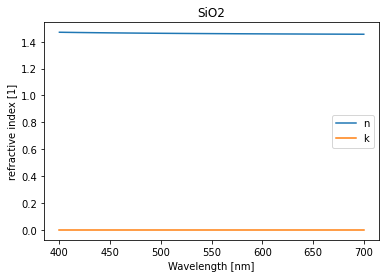

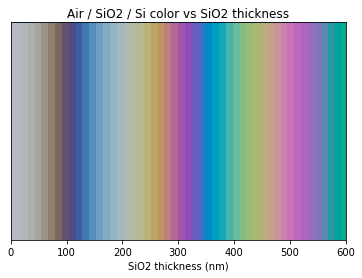

In [3]:
plot_film_thickness_vs_color(film_material="SiO2")

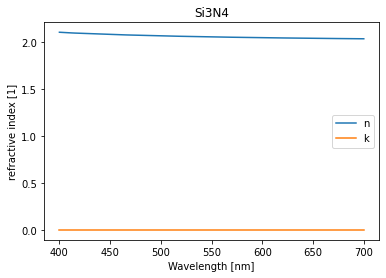

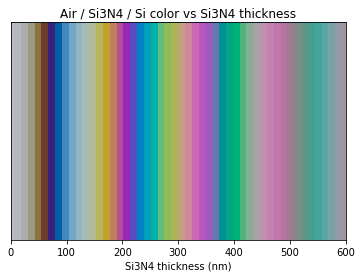

In [4]:
plot_film_thickness_vs_color(film_material="Si3N4")

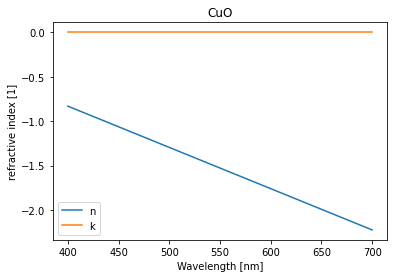

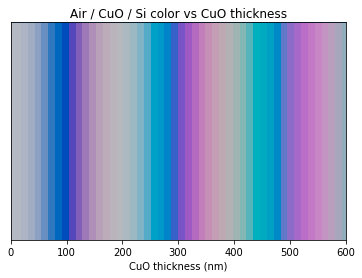

In [9]:
plot_film_thickness_vs_color(film_material="CuO", set_extinction_to_zero=True)

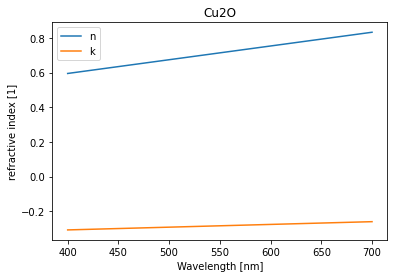

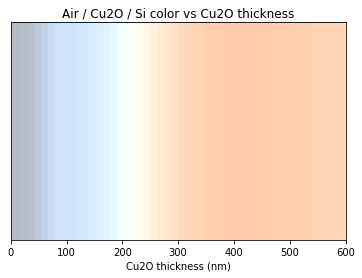

In [10]:
plot_film_thickness_vs_color(film_material="Cu2O", set_extinction_to_zero=False)

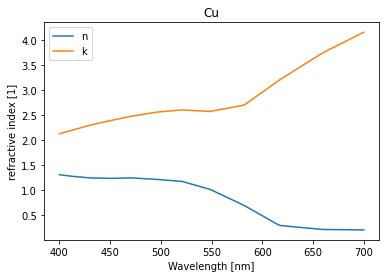

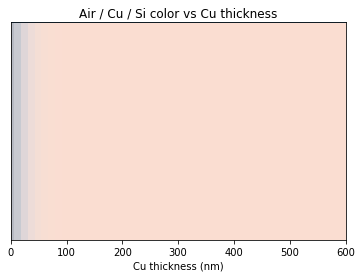

In [7]:
plot_film_thickness_vs_color(film_material="Cu")